In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
from torch.utils.data import Dataset
from IPython.display import Image
import numpy as np
import os
import glob
import random
from PIL import Image
from torch.utils.tensorboard import SummaryWriter
import torchvision.utils as vutils
from skimage.measure import compare_ssim, compare_psnr


#writer = SummaryWriter()
import warnings
warnings.filterwarnings(action='once')


device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('device = %s'%device)
print('torch version = %s'%(torch.__version__))
print('no. of GPUs = %d'%(torch.cuda.device_count()))

batch_size, n_in_channels, img_size = 10, 1, 10 #for toy problem
val_batch_size = 1
#dataloader
from torch.utils.data import DataLoader

#custom dataset class 
class ImageDataset(Dataset):
    def __init__(self, root, transforms_= None, unaligned = True, mode = 'train'):
        self.transform = transforms.Compose(transforms_)
        self.unaligned = unaligned

        self.files_A = sorted(glob.glob(os.path.join(root, '%s/groundtruth'% mode) + '/*.*'))
        self.files_B = sorted(glob.glob(os.path.join(root, '%s/labeled/data'% mode) + '/*.*'))
        self.files_B_labels = sorted(glob.glob(os.path.join(root, '%s/labeled/labels'% mode) + '/*.*'))
        
        assert len(self.files_B) == len(self.files_B_labels)


    def __getitem__(self, index):
        if self.unaligned:
            ground_truth = self.transform(Image.fromarray(np.load(self.files_A[random.randint(0, len(self.files_A) - 1)])))
        else:
            ground_truth = self.transform(Image.fromarray(np.load(self.files_A[index % len(self.files_A)])))
            
        # Get supervised data
        supervised = self.transform(Image.fromarray(np.load(self.files_B[index % len(self.files_B)])))
        label = np.load(self.files_B_labels[index % len(self.files_B)])
        
        

        return {'ground_truth': ground_truth, 'supervised': supervised, 'label': label}

    def __len__(self):
        return max(len(self.files_A), len(self.files_B))
    
transform_train_and_test = [transforms.ToTensor()]
datapath = '../data/l1_toy_data'

#training dataloader: test the performance for unaligned=False, i.e. for aligned/paired data
train_dataloader = DataLoader(ImageDataset(datapath, transforms_=transform_train_and_test, unaligned=False, mode = 'train'),\
                              batch_size = batch_size, shuffle = True) #the samples must be unaligned and shuffled
print('number of minibatches during training = %d'%len(train_dataloader))

#modified sigmoid 
def modified_sigmoid(x, alpha):
    x = 1 + torch.exp(-alpha*x)
    x = torch.div(torch.ones(x.size()).to(device), x)
    return x

device = cpu
torch version = 1.8.0
no. of GPUs = 0
number of minibatches during training = 100


/Users/wdiepeveen/PycharmProjects/Learned-Convex-Prior-Sampling/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [20]:
#build a convex discriminator (for 10 x 10 inputs)
n_filters = 5 #was 48 previously
filt_dim = 5
n_layers = 10

class icnn_new_model(nn.Module):
    def __init__(self, n_in_channels=1, n_filters=n_filters, filt_dim=filt_dim, n_layers=n_layers):
        super(icnn_new_model, self).__init__()
        
        self.n_layers = n_layers
        #these layers should have non-negative weights
        self.wz = nn.ModuleList([nn.Conv2d(n_filters, n_filters, kernel_size=filt_dim, stride=1, padding=2, bias=False) for i in range(self.n_layers)])
        
        #these layers can have arbitrary weights
        self.wx = nn.ModuleList([nn.Conv2d(n_in_channels, n_filters, kernel_size=filt_dim, stride=1, padding=2, bias=True) for i in range(self.n_layers+1)])
        
        #one final conv layer with nonnegative weights
        self.final_conv2d = nn.Conv2d(n_filters, 1, kernel_size=filt_dim, stride=1, padding=2, bias=False)
        
        #slope of leaky-relu
        self.negative_slope = 0.2 
        
    def forward(self, x):
        z = F.leaky_relu(self.wx[0](x), negative_slope=self.negative_slope)
        for layer in range(self.n_layers):
            z = F.leaky_relu(self.wz[layer](z) + self.wx[layer+1](x), negative_slope=self.negative_slope)
        z = self.final_conv2d(z)
        z_avg = F.avg_pool2d(z, z.size()[2:]).view(z.size()[0], -1)
        
        return z_avg
    

#realize the model: just one net which outputs a small number for true and large for something noisy 
mye = icnn_new_model().to(device) 


#manually initialize weights
#the following are initialized with non-negative weights
def initialize_weights(net, n_layers = n_layers, min_val = 0.0, max_val = 0.001):
    for layer in range(n_layers):
        net.wz[layer].weight.data = min_val + (max_val - min_val) * torch.rand(n_filters,n_filters,filt_dim,filt_dim).to(device)
    
    net.final_conv2d.weight.data = min_val + (max_val - min_val) * torch.rand(1,n_filters,filt_dim,filt_dim).to(device)
    return net

mye = initialize_weights(mye)

#for debugging
dummy_input = torch.rand(batch_size, n_in_channels, img_size, img_size).to(device)
mye_output = mye(dummy_input)
print(mye_output.size())

total_params = sum(p.numel() for p in mye.parameters())
print('total number of parameters in MYE = %d'%total_params)

torch.Size([10, 1])
total number of parameters in MYE = 7805


/Users/wdiepeveen/PycharmProjects/Learned-Convex-Prior-Sampling/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [21]:
###### FOR DEBUGGING ###### 

#check the contributions of each term in the ACR
noise_sd_for_training_stability = 0.0
for idx, batch in enumerate(train_dataloader):
    ############################################
    images = batch["ground_truth"].to(device) #true images
    batch_size = images.size()[0]

    #true images + slight noise for stability
    real_x = images + noise_sd_for_training_stability*torch.randn(batch_size,n_in_channels,img_size,img_size).to(device) 
    
    #for true image
    mye_output = mye(real_x)
    print('--- response to true image ---')
    print('contribution of the leaky-relu network = %.6f'%torch.sum(mye_output))
    
    break

--- response to true image ---
contribution of the leaky-relu network = 0.125018


In [22]:
#non-negativity penalty
def clamp_weights(net, n_layers = n_layers): #set negative weights to 0
    for layer in range(n_layers):
        net.wz[layer].weight.data.clamp_(0)
    
    net.final_conv2d.weight.data.clamp_(0)
    return net

import torch.autograd as autograd
def compute_gradient(net, samples): 
    interpolates = (samples).requires_grad_(True)
    validity = net(interpolates)
    fake = Variable(torch.FloatTensor(np.ones(validity.shape)), requires_grad=False)
    # Get gradient w.r.t. interpolates
    gradients = autograd.grad(outputs=validity, inputs=interpolates,
                              grad_outputs=fake, create_graph=True, retain_graph=True,
                              only_inputs=True)[0]
    
    gradients = gradients.view(gradients.size(0), -1)
    
    return gradients

def compute_hessian_penalty():
    k=9

def compute_l1_mye_penalty(samples, gradient, alpha, lamb): # for a general regularizer, we can use a simular function
    # Compute l2 gradient norm loss
    gradient_penalty = 1./2 * (gradient.norm(2, dim=1) ** 2).mean() 
    # Compute prior loss, i.e., l1 loss
    samples = samples.view(samples.size(0),-1)
    prior_penalty = (samples - lamb * gradient).norm(1, dim=1).mean()
    
    loss = lamb**2 * gradient_penalty + lamb * alpha * prior_penalty

    return loss, lamb**2 * gradient_penalty, lamb * alpha * prior_penalty

def compute_l2_penalty(net, samples, labels): 
    pred = net(samples)
    loss = ((pred - labels)**2).mean()

    return loss


In [23]:
###########
import itertools
betas = (0.5, 0.99) 

#trained without FoE
#optimizer_acr = torch.optim.Adam(itertools.chain(acr.parameters(),l2_net.parameters()), lr=2*1e-5, betas=betas, weight_decay=0.0)

# #when trained with FoE included
optimizer_mye = torch.optim.Adam(mye.parameters(), lr=2*1e-3, betas=betas, weight_decay=0.0)
#restart scheduler
scheduler_mye = torch.optim.lr_scheduler.StepLR(optimizer_mye, step_size=20, gamma=0.9)

# proximal map related variables
lamb = 1.
alpha = 1.

noise_sd_for_training_stability = 0.0
n_epochs = 10
num_minibatches = 20 #for display

avg_loss_mye_paired = []

for epoch in np.arange(n_epochs):
    
    # Reset losses
    total_loss = 0.0
    total_sup_loss = 0.0
    total_unsup_loss = 0.0
    total_gp_loss = 0.0
    total_pp_loss = 0.0
    
    for idx, batch in enumerate(train_dataloader):
        
        ############################################
        images = batch["ground_truth"].to(device) #true images
        supervised = batch["supervised"].to(device) #labeled images
        labels = batch["label"].to(device) #labels
        batch_size = images.size()[0]
        
        #true images + slight noise for stability
        real_x = images + noise_sd_for_training_stability*torch.randn(batch_size,n_in_channels,img_size,img_size).to(device) 
        
        gradient = compute_gradient(mye,real_x)
        
        unsup_loss, gp_loss, pp_loss = compute_l1_mye_penalty(real_x, gradient, alpha, lamb)
        sup_loss = compute_l2_penalty(mye, supervised, labels)
        
        loss = unsup_loss + sup_loss
#         loss = sup_loss
        
        #parameter update
        optimizer_mye.zero_grad()
        loss.backward()
        optimizer_mye.step()
        
        total_loss += loss.item()
        total_sup_loss += sup_loss.item()
        total_unsup_loss += unsup_loss.item()
        total_gp_loss += gp_loss.item()
        total_pp_loss += pp_loss.item()
        
        #clamp negative weights to 0
        mye = clamp_weights(mye) 
        #take scheduler steps
        scheduler_mye.step()
        
        if(idx % num_minibatches == num_minibatches-1):
            ####### compute avg. loss over minibatches #######
            avg_loss = total_loss/num_minibatches
            avg_sup_loss = total_sup_loss/num_minibatches
            avg_unsup_loss = total_unsup_loss/num_minibatches
            avg_gp_loss = total_gp_loss/num_minibatches
            avg_pp_loss = total_pp_loss/num_minibatches
            
            avg_loss_mye_paired.append(avg_loss)
            
            #reset the losses
            total_loss = 0.0
            total_gp_loss = 0.0
            total_pp_loss = 0.0
            
            print('==================')
            print('----single convex MYE----')
            print("epoch: [{}/{}], mini-batch: [{}/{}], avg_loss: {:.8f}, avg_gp_loss: {:.8f}, avg_pp_loss: {:.8f}".\
                  format(epoch+1, n_epochs, idx+1, len(train_dataloader), avg_loss, avg_gp_loss, avg_pp_loss))
            
            print('--- response to true image ---')
            mye_output_true = mye(real_x)
            print('contribution of the leaky-relu network = %.6f'%torch.sum(mye_output_true))

#             mye_output_fbp = mye(fake_x)
#             print('--- response to FBP ---')
#             print('contribution of the leaky-relu network = %.6f'%torch.sum(acr_output_fbp))
#             print('contribution of the FoE network = %.6f'%torch.sum(foe_output_fbp))
#             print('contribution of the l2-term = %.6f'%torch.sum(l2_term_fbp))
    
            #save the models 
            pretrained_network_path = '../models/l1reg_pretrained_nets/'
            os.makedirs(pretrained_network_path, exist_ok=True)
#             torch.save(acr.state_dict(),  pretrained_network_path + "acr_new_model_foe_included_" + 'epoch_%02d'%epoch + ".pt") 
#             torch.save(foe.state_dict(),  pretrained_network_path + "foe_net_foe_included_" + 'epoch_%02d'%epoch + ".pt") 
#             torch.save(l2_net.state_dict(),  pretrained_network_path + "l2_term_foe_included_" + 'epoch_%02d'%epoch + ".pt") 

            torch.save(mye.state_dict(),  pretrained_network_path + "mye_new_model_foe_included_paired.pt") 

----single convex MYE----
epoch: [1/10], mini-batch: [20/100], avg_loss: 1926.23902033, avg_gp_loss: 6.72471137, avg_pp_loss: 84.41478615
--- response to true image ---
contribution of the leaky-relu network = 737.681946
----single convex MYE----
epoch: [1/10], mini-batch: [40/100], avg_loss: 246.84215905, avg_gp_loss: 10.12647519, avg_pp_loss: 73.81557236
--- response to true image ---
contribution of the leaky-relu network = 736.184082
----single convex MYE----
epoch: [1/10], mini-batch: [60/100], avg_loss: 322.37224716, avg_gp_loss: 9.41525952, avg_pp_loss: 74.16152649
--- response to true image ---
contribution of the leaky-relu network = 545.955811
----single convex MYE----
epoch: [1/10], mini-batch: [80/100], avg_loss: 201.93245238, avg_gp_loss: 8.70635178, avg_pp_loss: 74.85011711
--- response to true image ---
contribution of the leaky-relu network = 631.085815
----single convex MYE----
epoch: [1/10], mini-batch: [100/100], avg_loss: 217.05816076, avg_gp_loss: 8.46712840, avg_p

----single convex MYE----
epoch: [8/10], mini-batch: [20/100], avg_loss: 176.54781782, avg_gp_loss: 5.23079886, avg_pp_loss: 79.65886078
--- response to true image ---
contribution of the leaky-relu network = 615.519165
----single convex MYE----
epoch: [8/10], mini-batch: [40/100], avg_loss: 205.56409779, avg_gp_loss: 5.22550972, avg_pp_loss: 80.14356346
--- response to true image ---
contribution of the leaky-relu network = 619.827393
----single convex MYE----
epoch: [8/10], mini-batch: [60/100], avg_loss: 177.56684241, avg_gp_loss: 5.31296563, avg_pp_loss: 80.43327942
--- response to true image ---
contribution of the leaky-relu network = 621.287048
----single convex MYE----
epoch: [8/10], mini-batch: [80/100], avg_loss: 186.68822563, avg_gp_loss: 5.35395010, avg_pp_loss: 79.40471230
--- response to true image ---
contribution of the leaky-relu network = 625.938354
----single convex MYE----
epoch: [8/10], mini-batch: [100/100], avg_loss: 170.91017915, avg_gp_loss: 5.23030069, avg_pp_

In [24]:
#save the models 
pretrained_network_path = '../models/l1reg_pretrained_nets/'
os.makedirs(pretrained_network_path, exist_ok=True)
# torch.save(acr.state_dict(),  pretrained_network_path + "acr_new_model_foe_included_" + 'epoch_%02d'%epoch + ".pt") 
# torch.save(foe.state_dict(),  pretrained_network_path + "foe_net_foe_included_" + 'epoch_%02d'%epoch + ".pt") 
# torch.save(l2_net.state_dict(),  pretrained_network_path + "l2_term_foe_included_" + 'epoch_%02d'%epoch + ".pt") 

# torch.save(acr.state_dict(),  pretrained_network_path + "acr_new_model_foe_included_paired.pt")
# torch.save(foe.state_dict(),  pretrained_network_path + "foe_net_foe_included_paired.pt")
# torch.save(l2_net.state_dict(),  pretrained_network_path + "l2_term_foe_included_paired.pt")

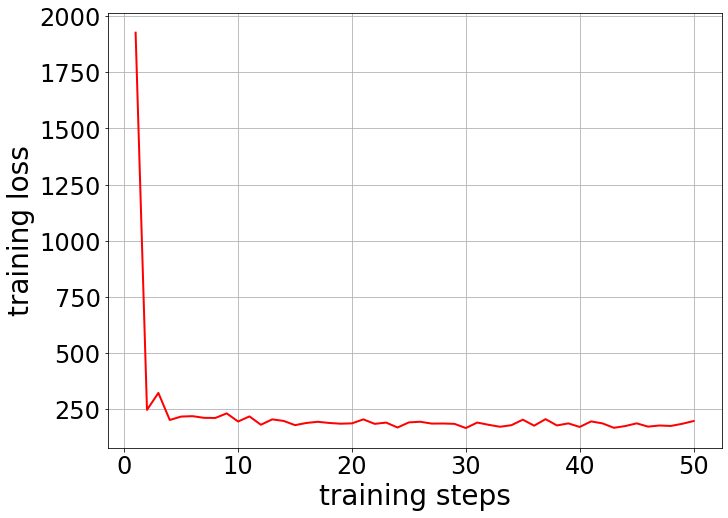

In [25]:
import matplotlib.pyplot as plt
pretrained_network_path = '../models/l1reg_pretrained_nets/'

avg_loss_mye_paired_arr = np.array(avg_loss_mye_paired, dtype=np.float32)
# avg_loss_mye_unpaired_arr = np.load(pretrained_network_path + "avg_loss_mye_unpaired_arr.npy")
np.save(pretrained_network_path + "avg_loss_mye_paired_arr.npy", avg_loss_mye_paired_arr)
train_steps = np.arange(1, 1+avg_loss_mye_paired_arr.size)

# plt.plot(train_steps, avg_loss_mye_paired_arr, 'r', train_steps, avg_loss_acr_unpaired_arr, 'b', linewidth=2.0)
# plt.legend(['paired', 'unpaired'], fontsize=24.0)


plt.plot(train_steps, avg_loss_mye_paired_arr, 'r', linewidth=2.0)

# plt.plot(train_steps, avg_loss_mye_unpaired_arr, 'b', linewidth=2.0)

plt.gcf().set_size_inches(11.0,8.0)
plt.xlabel('training steps', fontsize=28.0)
plt.ylabel('training loss', fontsize=28.0)
plt.tick_params(axis='both', which='major', labelsize=24.0)
plt.grid()

plt.savefig(pretrained_network_path + 'unpaired_train.png', bbox_inches='tight', transparent = False, pad_inches=0.1)
#plt.savefig(pretrained_network_path + 'paired_vs_unpaired_train_combined.png', bbox_inches='tight', transparent = False, pad_inches=0.1)
#plt.savefig(pretrained_network_path + 'paired_train.png', bbox_inches='tight', transparent = False, pad_inches=0.1)

plt.show()

In [26]:
#check convexity of the net
n_trials = 50
convexity = 0
for trial in np.arange(n_trials):
    x1 = torch.rand(dummy_input.size()).to(device)
    x2 = torch.rand(dummy_input.size()).to(device)
    alpha = torch.rand(1).to(device)

    cvx_combo_of_input = mye(alpha * x1 + (1-alpha)*x2)
    cvx_combo_of_output = alpha * mye(x1) + (1-alpha)*mye(x2)

    convexity += (cvx_combo_of_input.mean() <= cvx_combo_of_output.mean())
if(convexity == n_trials):
    print('the net is %s'%'convex') 
else:
    print('the net is %s'%'non-convex')

/Users/wdiepeveen/PycharmProjects/Learned-Convex-Prior-Sampling/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


the net is convex


(1000, 1, 10, 10)
(1000,)


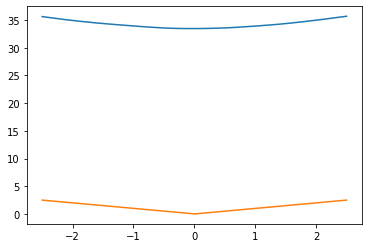

In [27]:
# compare output to exact solution
steps = 1000
x_ij = torch.linspace(start=-2.5, end=2.5,steps=steps)
print((steps,) + real_x[0].shape)
x = torch.zeros((steps,) + real_x[0].shape)
x[:,0,2,3] = x_ij
g_lambda = mye(x)

def mye_l1(lambd,x):
    z = np.zeros((x.shape[0], x.shape[2], x.shape[3]))
    for k in range(x.shape[0]):
        for i in range(x.shape[2]):
            for j in range(x.shape[3]):
#                 if i==2 and j==3:
#                     print(x[k,0,i,j])
                if x[k,0,i,j].abs() < lambd:
                    z[k,i,j] = 1/(2*lambd) * x[k,0,i,j]**2
                else:
                    z[k,i,j] = np.abs(x[k,0,i,j]) - lambd/2

    mye = np.sum(z,axis=(1,2))

    return mye
        
    
        
gt = mye_l1(alpha*lamb,x)
print(gt.shape)

plt.plot(x_ij.detach().numpy(),g_lambda.detach().numpy())
plt.plot(x_ij.detach().numpy(),gt)
# Plot ground truth

plt.show()